United States market

Price to Cash flow from 10 to 20

In [119]:
import sys

import pandas
import sklearn
import sklearn.tree
import sklearn.cluster
import sklearn.preprocessing

sys.path.append('investpy')

import investpy
import random
import numpy as np
import scipy
import scipy.stats
import pandas_ta
import traceback

In [120]:
n = 50
index = 'NASDAQ'
country = "United States"
date_from = "01/09/2019"
date_to = "01/09/2020"

In [121]:
index_data = investpy.indices.get_index_historical_data(index, country, date_from, date_to)
correct_days = len(index_data)
print(f"Days in period: {correct_days}")

Days in period: 253


In [122]:
class StockData:
  def calculate_rsi(self, periods = 14, ema = True):
    close_delta = self.data.loc[:, 'Close'].diff()

    up = close_delta.clip(lower=0)
    down = -1 * close_delta.clip(upper=0)

    if ema:
        ma_up = up.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
        ma_down = down.ewm(com = periods - 1, adjust=True, min_periods = periods).mean()
    else:
        ma_up = up.rolling(window = periods, adjust=False).mean()
        ma_down = down.rolling(window = periods, adjust=False).mean()

    rsi = ma_up / ma_down
    rsi = 100 - (100/(1 + rsi))
    return rsi

  def calculate_info(self):
    self.average = self.close.mean()
    self.abs_growth = self.close[-1] - self.close[0]
    self.rel_growth = self.abs_growth/self.close[0]
    self.abs_growth_to_rel_growth = self.abs_growth/self.rel_growth
    self.variance = self.close.std() / self.average
    self.range = self.close.max() - self.close.min()
    self.range_ln = np.log(self.range)
    self.oscillation = self.average / self.range

    self.stock_diff = np.array([(self.close[i]/self.close[i-1])-1 for i in range(1, len(self.close))])
    self.profit_avg = self.stock_diff.mean()
    self.profit_var = self.stock_diff.std()

    self.ratios = investpy.stocks.get_stock_ratios(self.stock, self.country)

    self.debt_to_equity = self.ratios["Total Debt to Equity"].to_numpy()[0]
    if np.isnan(self.debt_to_equity):
        raise ValueError("Debt to equity is nan")

    self.basic_eps = self.ratios["Basic EPS"].to_numpy()[0]
    if np.isnan(self.basic_eps):
        raise ValueError("Basic EPS is nan")

    self.pe_ratio = self.ratios["P/E Ratio"].to_numpy()[0]
    if np.isnan(self.pe_ratio):
        raise ValueError("Basic EPS is nan")

    self.dividend_yield = self.ratios["Dividend Yield"].to_numpy()[0]
    if np.isnan(self.dividend_yield):
        raise ValueError("Dividend Yeild is nan")

    self.current_ratio = self.ratios["Current Ratio"].to_numpy()[0]
    if np.isnan(self.current_ratio):
        raise ValueError("Current Ratio is nan")

    self.roe = self.ratios["Return on Equity"].to_numpy()[0]
    if np.isnan(self.roe):
        raise ValueError("Return on Equity is nan")


    self.rsi = pandas_ta.rsi(self.data['Close'], length = correct_days-1).iloc[-1]
    self.volatility = self.close.std()

    self.beta = np.correlate(self.close, index_data['Close'].to_numpy())[0]/np.std(index_data['Close'].to_numpy())

    # index_data.loc[:, 'Close'].to_numpy()

    self.spearman = scipy.stats.spearmanr(self.close, list(range(len(self.close)))).correlation
    # stability of quotes to2810.xlsx candles (22)
    # делаем линейную регрессию, считаем квадраты отклонений от неё, stability of quoates = 1 - среднеквадратичное отклонение / сумму квадратов отклонений

    # stability = среднее положительных приростов / среднеее отрицательных приростов
    # rsi = количество положительных приростов / количество отрицательных приростов

  def __init__(self, stock, country, date_from, date_to, data):
    self.stock = stock
    self.country = country
    self.date_from = date_from
    self.date_to = date_to
    self.data = data
    self.close = data.loc[:, 'Close'].to_numpy()
    self.calculate_info()

  def __repr__(self):
    return f"""
stock: {self.stock},
country: {self.country},
date_from: {self.date_from},
date_to: {self.date_to},
data: 
{self.data.head()}"""

In [123]:
def get_stock_historical_data(stock,
                              country,
                              from_date,
                              to_date):
  df = investpy.get_stock_historical_data(stock=stock,
                                          country=country,
                                          from_date=from_date,
                                          to_date=to_date,
                                          order='ascending',
                                          interval="Daily")
  return df.loc[:, ['Open', 'High', 'Low', 'Close']]

In [124]:
def get_random_stock_data_n(n, countries, date_from, date_to, correct_days, debug=False):
  stocks = []
  for country in countries:
    country_stocks = investpy.get_stocks_list(country)
    country_stocks = list(filter(lambda s: not s.endswith("_p"), country_stocks)) # _p is privileged stock
    country_stocks = zip(country_stocks, [country] * len(country_stocks))
    stocks += country_stocks
  random.shuffle(stocks)
  stock_data = []
  for (stock, country) in stocks:
    try:
      data = get_stock_historical_data(stock, country, date_from, date_to)
      stock_datum = StockData(stock, country, date_from, date_to, data)
      if len(stock_datum.close) != correct_days:
        continue
#       if stock_datum.profit_avg < 0:
#         continue
      stock_data.append(stock_datum)
      print(f"{len(stock_data)}/{n}")
    except Exception as e:
      if debug:
          traceback.print_exc()
        # print(e)
      # possibly, not available in selected date interval
    if len(stock_data) >= n:
      break
  return stock_data

In [125]:
def get_screener_stock_data_n(n, selected_stocks, country, date_from, date_to, correct_days, debug=False):
    stock_data = []
    for stock in selected_stocks:
        try:
            data = get_stock_historical_data(stock, country, date_from, date_to)
            if len(data.loc[:, 'Close']) != correct_days:
                continue
            stock_datum = StockData(stock, country, date_from, date_to, data)
            stock_data.append(stock_datum)
            print(f"{len(stock_data)}/{n}")
        except Exception as e:
            if debug:
                traceback.print_exc()
            # possibly, not available in selected date interval
        if len(stock_data) >= n:
            break
    return stock_data

In [126]:
def get_stock_data(method: str = 'screener', debug=False):
    if method == 'random':
        stock_data = get_random_stock_data_n(n, [country], date_from, date_to, correct_days, debug=debug)
    elif method == 'screener':
        selected_stocks_df = investpy.screener(
            investpy.ScreenerParams()
                .with_country(country)
                .add_filter("Price to Cash Flow (MRQ)", 10, 20),
            as_dataframe=True, n_results=150)
        selected_stocks = selected_stocks_df['symbol'].to_numpy()
        selected_stocks = list(set(selected_stocks))
        stock_data = get_screener_stock_data_n(n, selected_stocks, country, date_from, date_to, correct_days, debug=debug)
    else:
        raise ValueError(f"Unexpected method {method}")
    print(f"Selected {len(stock_data)} stocks: {list(map(lambda x: x.stock, stock_data))}")

    return stock_data

In [127]:
stock_data = get_stock_data('screener', debug=False)

1/50
2/50
3/50
4/50
5/50
6/50
7/50
8/50
9/50
10/50
11/50
12/50
13/50
14/50
15/50
16/50
17/50
18/50
19/50
20/50
21/50
22/50
23/50
24/50
25/50
26/50
27/50
28/50
29/50
30/50
31/50
32/50
33/50
34/50
Selected 34 stocks: ['ACCO', 'EC', 'NTTYY', 'NWSA', 'CRH', 'ARCB', 'CEO', 'ANDE', 'AIR', 'BRDCY', 'VALE', 'APOG', 'RDSb', 'BHP', 'CTSH', 'ATHM', 'ERIC', 'RS', 'IBA', 'TS', 'AGCO', 'ALG', 'BBL', 'HMC', 'BTI', 'AIMC', 'ODC', 'ADRNY', 'TELNY', 'HCMLY', 'AMGN', 'HNNA', 'RDSa', 'GFI']


In [128]:
from scipy.optimize import Bounds, minimize
import numpy as np
import matplotlib.pyplot as plt

labels =      list(map(lambda x: x.stock, stock_data))
mu = np.array(list(map(lambda x: 100*x.profit_avg, stock_data)))

var = np.array(list(map(lambda x: x.profit_var, stock_data)))

R = np.corrcoef(np.array(list(map(lambda x: x.stock_diff, stock_data))))

var = np.expand_dims(var, axis=0)
S = var.T @ var * R
# Initial guess
x = np.ones(len(labels)) * (1/len(labels))

def value(x):
        return x.T @ S @ x

def optimize_portfolio(r):
    mu_cons = {'type': 'eq',
                 'fun': lambda x: np.sum(mu @ x.T) - r
                }
    sum_cons = {'type': 'eq',
                 'fun': lambda x: np.sum(x) - 1
                }
    bnds = Bounds (np.ones_like(x) * 0.0, np.ones_like(x))

    res = minimize(value, x, method='SLSQP', 
                   constraints=[mu_cons, sum_cons], bounds=bnds)
    return res

rate = np.linspace(0, 1, 100)
opti = list(map(optimize_portfolio, rate))
y = np.array(list(map(lambda res: res.x, opti))).T

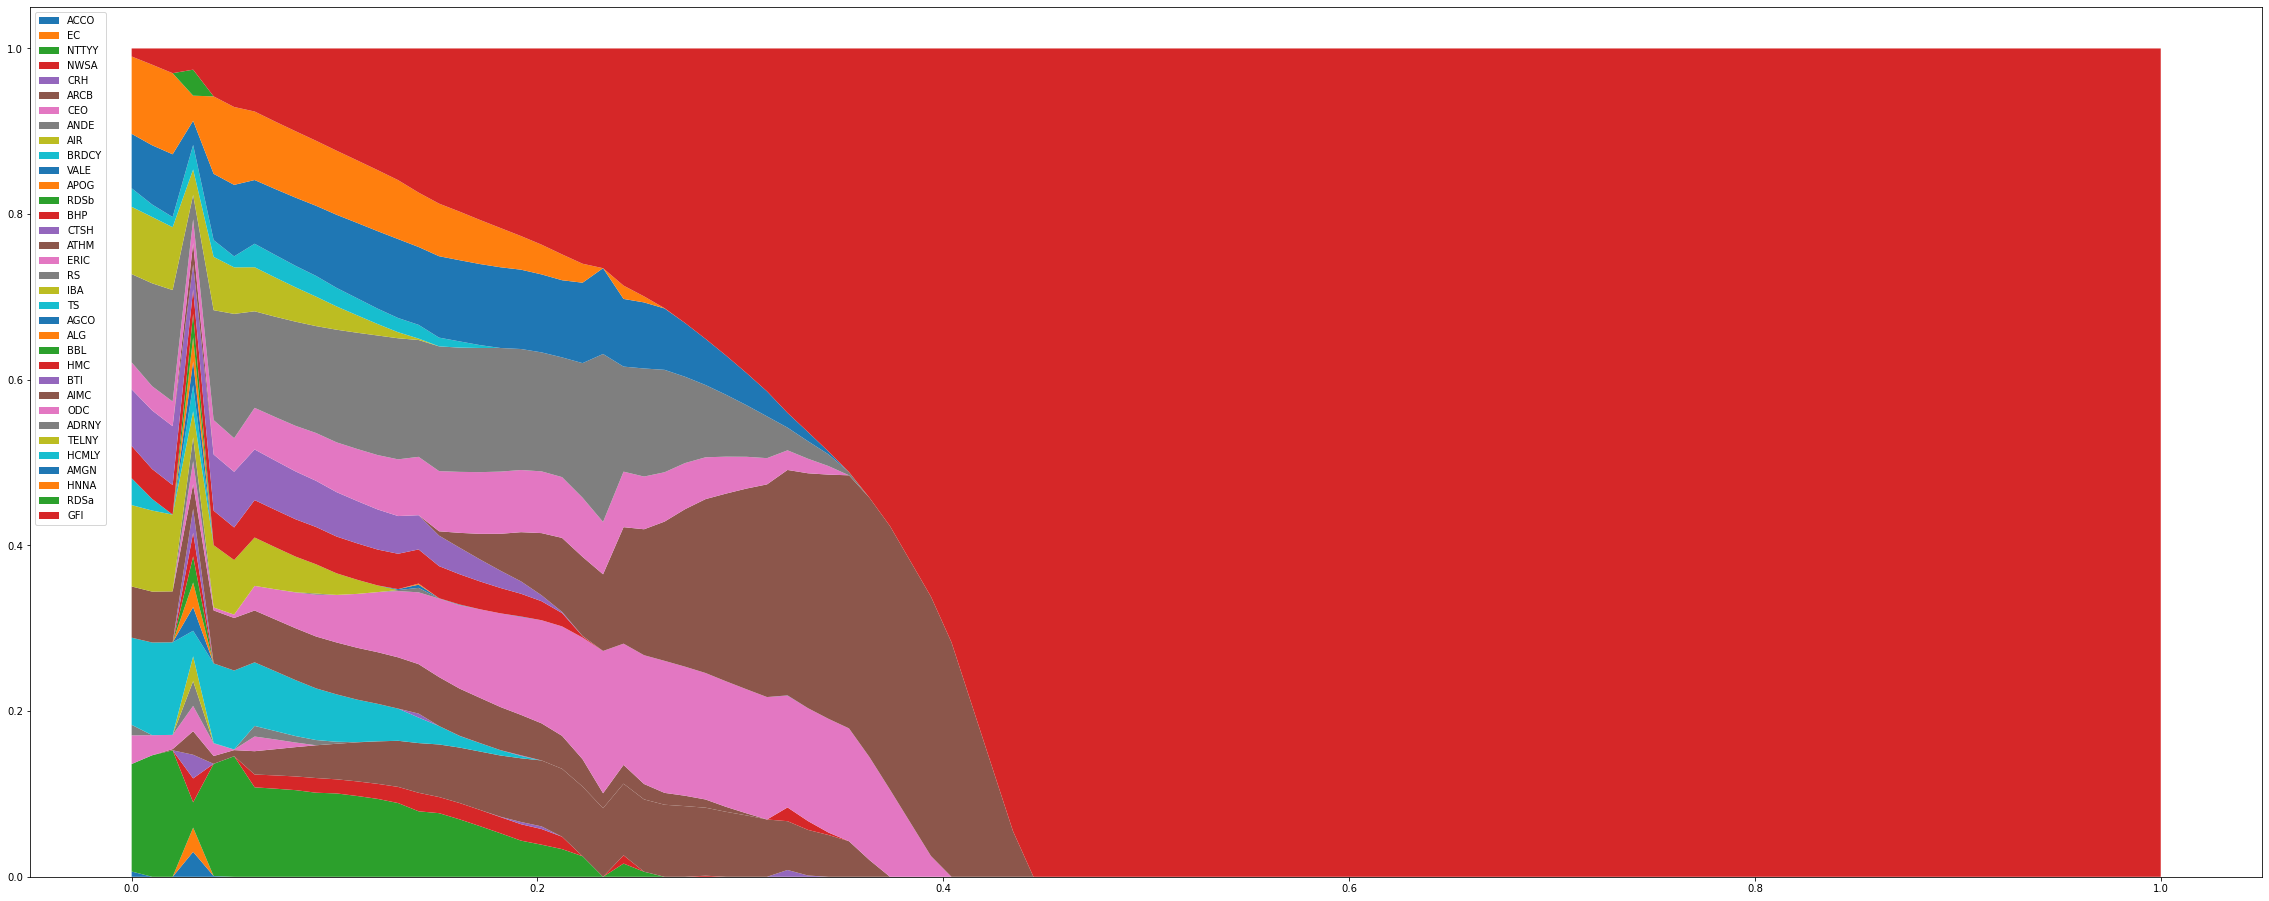

In [129]:
plt.figure(figsize=(40, 16))
plt.stackplot(rate, y, labels=labels)
plt.legend(loc='upper left')
plt.show()

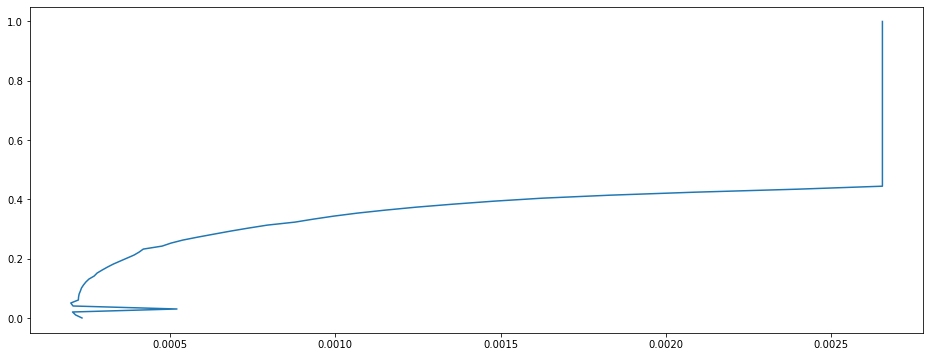

In [130]:
opti_vars = list(map(lambda res: res.fun, opti))
plt.figure(figsize=(16, 6))
plt.plot(opti_vars, rate)
plt.show()

In [131]:
def to_ndarray_invest(stock_data):
    features = []
    features.append(list(map(lambda x: x.beta, stock_data)))
    features.append(list(map(lambda x: x.debt_to_equity, stock_data)))
    features.append(list(map(lambda x: x.dividend_yield, stock_data)))
    features.append(list(map(lambda x: x.current_ratio, stock_data)))
    features.append(list(map(lambda x: x.roe, stock_data)))
    # features.append(list(map(lambda x: x.spearman, stock_data)))
    # features.append(list(map(lambda x: x.basic_eps, stock_data)))
    # features.append(list(map(lambda x: x.pe_ratio, stock_data)))
    return np.array(features).T

def to_ndarray_trade(stock_data):
    features = []
    features.append(list(map(lambda x: x.range_ln, stock_data)))
    features.append(list(map(lambda x: x.rsi, stock_data)))
    features.append(list(map(lambda x: x.volatility, stock_data)))
    features.append(list(map(lambda x: x.oscillation, stock_data)))
    # features.append(list(map(lambda x: x.spearman, stock_data)))
    # features.append(list(map(lambda x: x.basic_eps, stock_data)))
    features.append(list(map(lambda x: x.pe_ratio, stock_data)))
    return np.array(features).T

In [142]:
stock_data_features = to_ndarray_trade(stock_data)
print(stock_data_features)

[[  1.85941812  47.87164135   1.66560544   1.21808701  10.42      ]
 [  2.65815943  47.60731221   3.90933691   1.02699214  14.02      ]
 [  1.8050047   48.39540519   1.14217734   3.9819599   12.01      ]
 [  1.96711236  53.04185246   1.85455192   1.76693109  42.26      ]
 [  3.10009229  51.76551044   4.63028624   1.56587081  26.04      ]
 [  2.92852352  53.7999775    4.64842964   1.39526114  16.51      ]
 [  4.56080024  47.09424726  23.78313326   1.39706338   6.49      ]
 [  2.8255369   48.88364529   4.35919535   1.12498038  15.66      ]
 [  3.74809131  45.02509422  12.53693868   0.7438141   18.08      ]
 [  2.03470565  47.18663464   2.03646932   2.27000956  29.49      ]
 [  1.95302762  50.92173693   1.65590893   1.54051524   3.73      ]
 [  3.44903471  46.26727124   8.0631366    0.91242428 449.09      ]
 [  3.74714836  43.16116835  13.37298983   1.04420632  38.67      ]
 [  3.29768701  52.9910553    6.24194187   1.79881058  11.9       ]
 [  3.39484391  52.04114279   5.94939559   2.000

In [143]:
def get_correlation(data, high_coef=0.8):
    coercoef = np.corrcoef(data.T)
    for (i, row) in enumerate(coercoef):
        for (j, val) in enumerate(row):
            if i < j and abs(val) >= high_coef:
                print('High correlation detected for features {} and {}'.format(i, j))
    return coercoef

In [144]:
get_correlation(stock_data_features)

High correlation detected for features 0 and 2


array([[ 1.        , -0.17071042,  0.91578874, -0.20590129,  0.130349  ],
       [-0.17071042,  1.        , -0.27289043,  0.20215358, -0.2110507 ],
       [ 0.91578874, -0.27289043,  1.        , -0.18418981,  0.0712981 ],
       [-0.20590129,  0.20215358, -0.18418981,  1.        , -0.2094364 ],
       [ 0.130349  , -0.2110507 ,  0.0712981 , -0.2094364 ,  1.        ]])

In [145]:
sc = sklearn.preprocessing.StandardScaler()
sc.fit(stock_data_features)
stock_data_features_normalized = sc.transform(stock_data_features)

In [146]:
if False:
    print('KMeans')
    for n_clusters in range(2, 10):
        kmeans = sklearn.cluster.KMeans(n_clusters=n_clusters)
        kmeans.fit(stock_data_features_normalized)
        labels = kmeans.labels_
        print(n_clusters, sklearn.metrics.silhouette_score(stock_data_features_normalized, labels, metric='euclidean'))

In [147]:
def draw_boxplot(X, labels, colors=None):
    # X[i] -- фичи для акции i
    # label[i] -- номер кластера акции i
    # X.shape = (#stocks, #features)

    fig, ax = plt.subplots(figsize=(10, 7))
    legend1, legend2 = [], []
    for label in range(1, max(labels) + 1):
        my = X[np.where(labels == label)]
        if colors is None:
            clr = list(np.random.random(3))
            clr2 = list(np.random.random(3))
        else:
            clr  = colors[label-1][0]
            clr2 = colors[label-1][1]
        bp = ax.boxplot(my, patch_artist=True)
        for element in ['boxes', 'whiskers', 'fliers', 'means', 'medians', 'caps']:
            plt.setp(bp[element], color=clr)
        for patch in bp['boxes']:
            patch.set(facecolor=clr2)
        legend1.append(bp["boxes"][0])
        legend2.append('Cluster ' + str(label-1))
    ax.legend(legend1, legend2)
    # plt.ylim(0, 1)
    plt.show()

In [148]:
def index_by_stock_data(stock_data_closes):
    # closes = []
    # for i in stock_data:
    #     closes.append(i.close)
    return scipy.stats.mstats.gmean(np.array(stock_data_closes))

In [149]:
from scipy.optimize import Bounds, minimize
import numpy as np
import matplotlib.pyplot as plt

def best_representative_of_cluster(stock_data, labels):
    stock_data_closes = []
    for stock_datum in stock_data:
        stock_data_closes.append(stock_datum.close)
    stock_data_closes = np.array(stock_data_closes)

    best_of_cluster = []
    for label in range(1, max(labels)+1):
        global_indices = np.array(list(range(len(stock_data))))[np.where(labels == label)]
        stock_data_closes_in_cluster = stock_data_closes[np.where(labels == label)]
        print("Cluster {}: {}".format(label, ' '.join(np.array(list(map(lambda x: x.stock, stock_data)))[np.where(labels == label)])))

        index_in_cluster = index_by_stock_data(stock_data_closes_in_cluster)

        x = np.ones(len(stock_data_closes_in_cluster)) * (1/len(stock_data_closes_in_cluster))

        def value(x):
            return (stock_data_closes_in_cluster.T @ x - index_in_cluster).std()

        sum_cons = {'type': 'eq',
                     'fun': lambda x: np.sum(x) - 1
                    }
        bnds = Bounds (np.zeros_like(x), np.ones_like(x))

        opti = minimize(value, x, method='SLSQP', constraints=[sum_cons], bounds=bnds)

        best_of_cluster.append((global_indices[np.argmax(opti.x)], np.max(opti.x)))
    return best_of_cluster

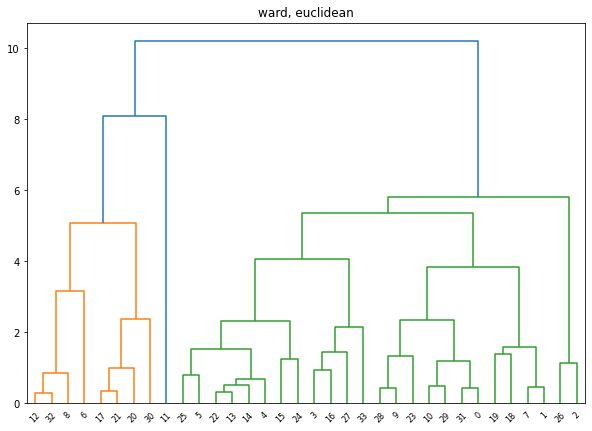

Method ward, Metric euclidean, Number of clusters 2, Silhouette 0.3554711279556835
Method ward, Metric euclidean, Number of clusters 3, Silhouette 0.34293214557224566
Method ward, Metric euclidean, Number of clusters 4, Silhouette 0.3112259270466309
Method ward, Metric euclidean, Number of clusters 5, Silhouette 0.25748510756627546
Method ward, Metric euclidean, Number of clusters 6, Silhouette 0.2868914215132591


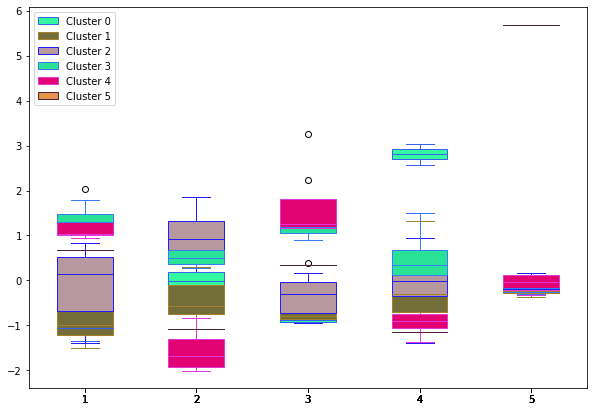

Cluster 1: NTTYY ODC
Cluster 2: ACCO EC ANDE BRDCY VALE IBA TS HMC TELNY HCMLY HNNA
Cluster 3: NWSA CRH ARCB BHP CTSH ATHM ERIC BBL BTI AIMC ADRNY GFI
Cluster 4: RS AGCO ALG AMGN
Cluster 5: CEO AIR RDSb RDSa
Cluster 6: APOG
Best representatives of clusters
Cluster 0: NTTYY with coefficient 0.5853984586437626
Cluster 1: ACCO with coefficient 0.15468344027516504
Cluster 2: GFI with coefficient 0.2992687951034643
Cluster 3: AGCO with coefficient 0.3407412409390036
Cluster 4: RDSb with coefficient 0.5326583885817118
Cluster 5: APOG with coefficient 1.0


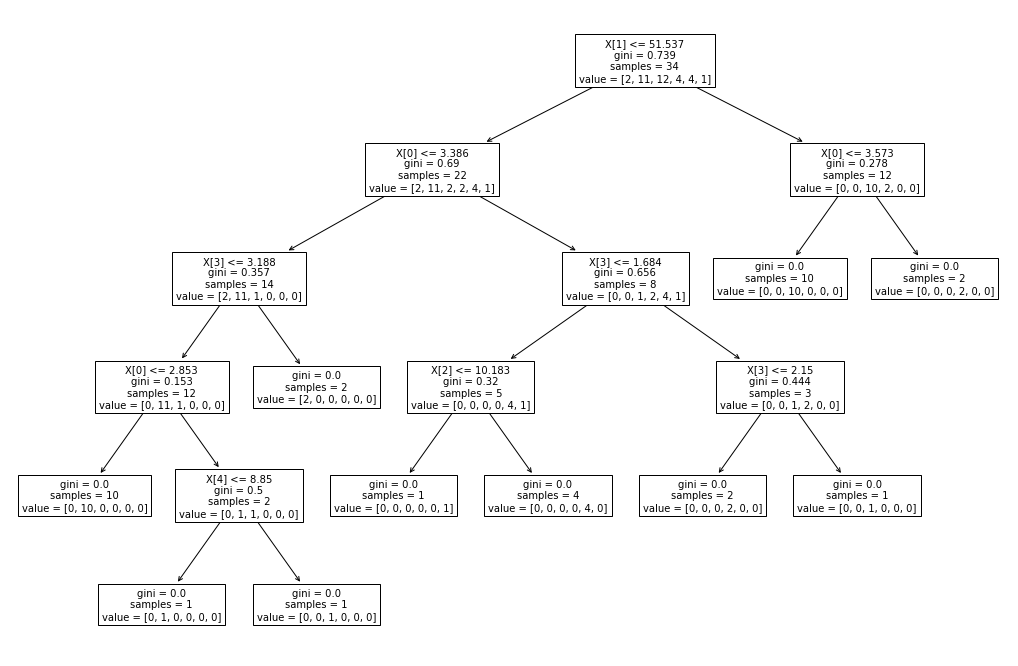

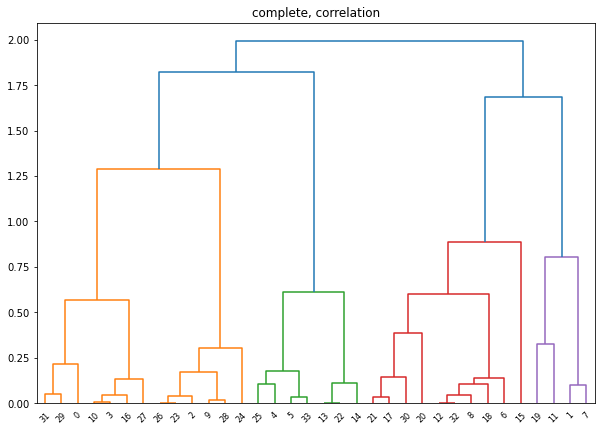

Method complete, Metric correlation, Number of clusters 2, Silhouette 0.5326572515411376
Method complete, Metric correlation, Number of clusters 3, Silhouette 0.5536373668481337
Method complete, Metric correlation, Number of clusters 4, Silhouette 0.553315279995872
Method complete, Metric correlation, Number of clusters 5, Silhouette 0.6091924583501996
Method complete, Metric correlation, Number of clusters 6, Silhouette 0.5444619048159859


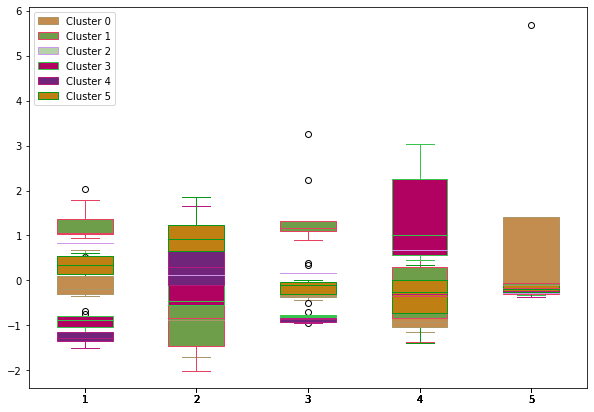

Cluster 1: EC ANDE APOG TS
Cluster 2: CEO AIR RDSb RS IBA AGCO ALG AMGN RDSa
Cluster 3: ATHM
Cluster 4: NTTYY BRDCY HMC BTI ODC TELNY
Cluster 5: ACCO NWSA VALE ERIC ADRNY HCMLY HNNA
Cluster 6: CRH ARCB BHP CTSH BBL AIMC GFI
Best representatives of clusters
Cluster 0: EC with coefficient 0.32016193431289586
Cluster 1: RDSb with coefficient 0.3165400914053304
Cluster 2: ATHM with coefficient 1.0
Cluster 3: TELNY with coefficient 0.23363120729779138
Cluster 4: ACCO with coefficient 0.20655652146364176
Cluster 5: GFI with coefficient 0.3619630532697976


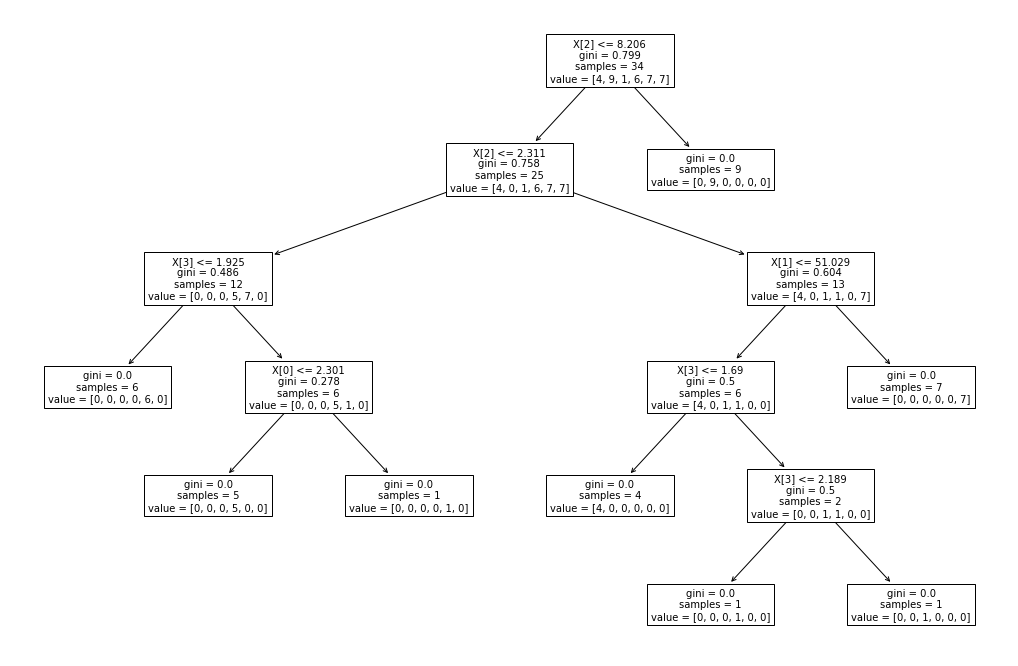

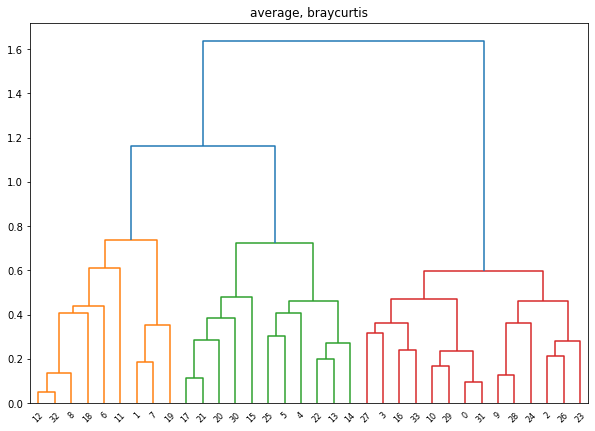

Method average, Metric braycurtis, Number of clusters 2, Silhouette 0.48439630924231725
Method average, Metric braycurtis, Number of clusters 3, Silhouette 0.48816225105384026
Method average, Metric braycurtis, Number of clusters 4, Silhouette 0.38220542231417265
Method average, Metric braycurtis, Number of clusters 5, Silhouette 0.3828878078649355
Method average, Metric braycurtis, Number of clusters 6, Silhouette 0.37477122708909094


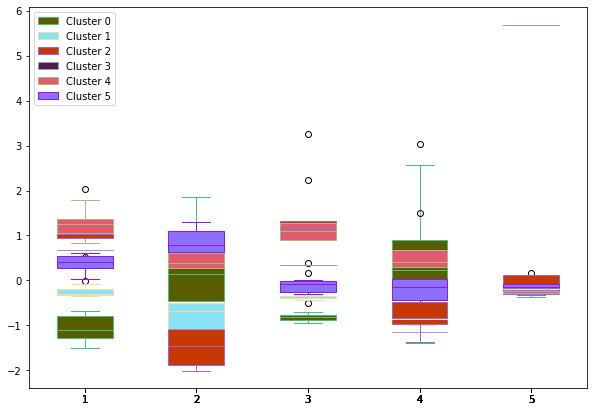

Cluster 1: ACCO NTTYY NWSA BRDCY VALE ERIC HMC BTI ODC ADRNY TELNY HCMLY HNNA GFI
Cluster 2: EC ANDE TS
Cluster 3: CEO AIR RDSb IBA RDSa
Cluster 4: APOG
Cluster 5: ATHM RS AGCO ALG AMGN
Cluster 6: CRH ARCB BHP CTSH BBL AIMC
Best representatives of clusters
Cluster 0: ACCO with coefficient 0.16028672761317383
Cluster 1: EC with coefficient 0.37856782610969103
Cluster 2: RDSb with coefficient 0.47725667833281843
Cluster 3: APOG with coefficient 1.0
Cluster 4: AGCO with coefficient 0.3175700154083335
Cluster 5: AIMC with coefficient 0.21164686320671947


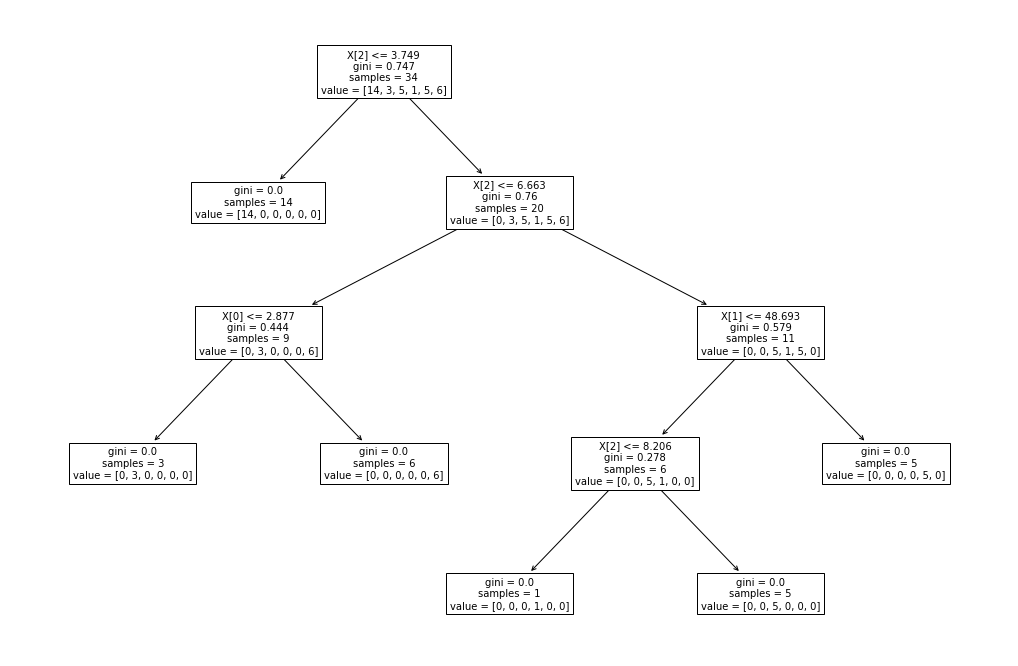

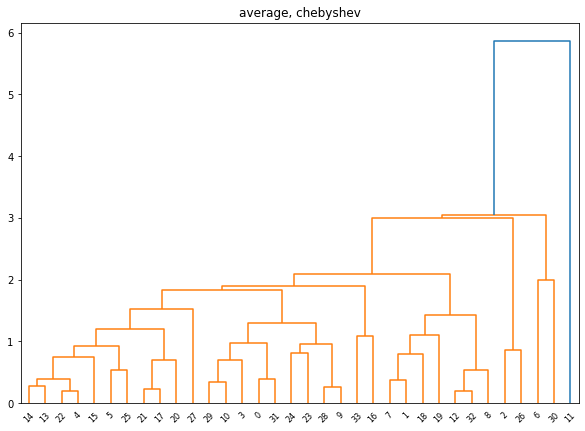

Method average, Metric chebyshev, Number of clusters 2, Silhouette 0.6368418070843419
Method average, Metric chebyshev, Number of clusters 3, Silhouette 0.3421610619271932
Method average, Metric chebyshev, Number of clusters 4, Silhouette 0.32030426356076463
Method average, Metric chebyshev, Number of clusters 5, Silhouette 0.2741399818783871
Method average, Metric chebyshev, Number of clusters 6, Silhouette 0.23299374672644535


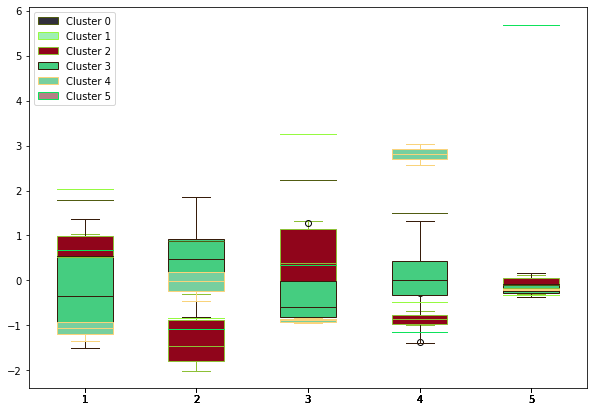

Cluster 1: AMGN
Cluster 2: CEO
Cluster 3: EC ANDE AIR RDSb IBA TS RDSa
Cluster 4: ACCO NWSA CRH ARCB BRDCY VALE BHP CTSH ATHM ERIC RS AGCO ALG BBL HMC BTI AIMC ADRNY TELNY HCMLY HNNA GFI
Cluster 5: NTTYY ODC
Cluster 6: APOG
Best representatives of clusters
Cluster 0: AMGN with coefficient 1.0
Cluster 1: CEO with coefficient 1.0
Cluster 2: EC with coefficient 0.23410780293030084
Cluster 3: GFI with coefficient 0.14619383157137986
Cluster 4: NTTYY with coefficient 0.5853984586437626
Cluster 5: APOG with coefficient 1.0


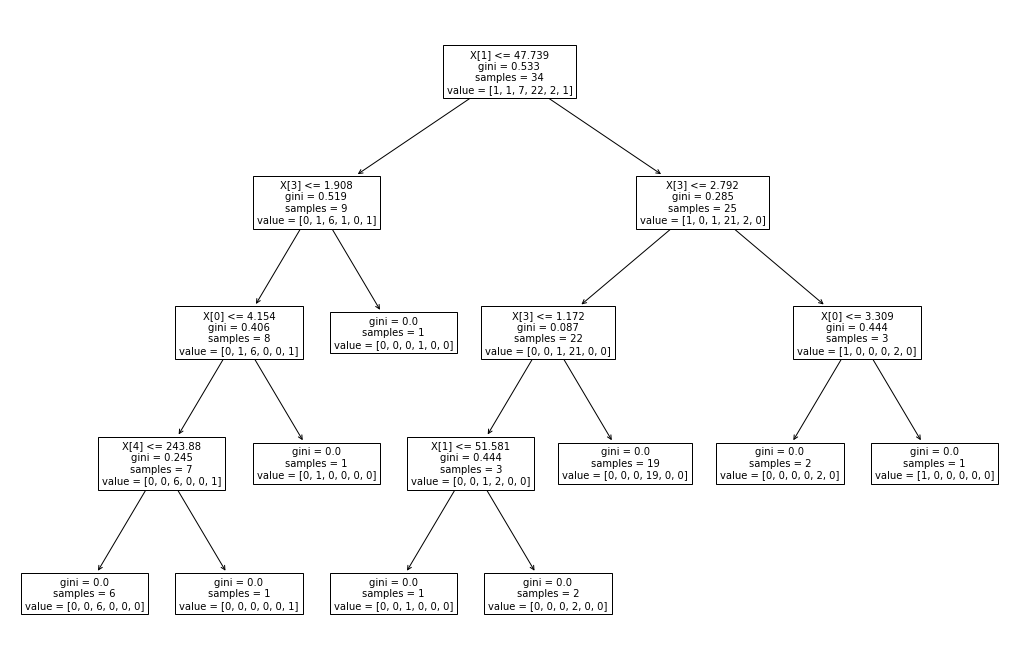

In [150]:
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib import pyplot as plt
import time

methods = ['single', 'ward', 'complete', 'average', 'weighted', 'centroid', 'median']
metrics =  ['braycurtis', 'canberra', 'chebyshev', 'cityblock',
            'correlation', 'cosine', 'dice', 'euclidean', 'hamming',
            'jaccard', 'jensenshannon', 'kulsinski', 'mahalanobis', 'matching',
            'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean',
            'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule']

def labels_by_linked(linked, n_clusters):
    return scipy.cluster.hierarchy.fcluster(linked, t=n_clusters, criterion='maxclust')

all_labels = []

for (method, metric) in [('ward', 'euclidean'), ('complete', 'correlation'), ('average', 'braycurtis'), ('average', 'chebyshev')]:
    linked = linkage(stock_data_features_normalized, method=method, metric=metric, optimal_ordering=True)

    labelList = range(0, len(stock_data_features_normalized))

    plt.figure(figsize=(10, 7))
    dendrogram(linked,
                orientation='top',
                labels=labelList,
                distance_sort='descending',
                show_leaf_counts=True)
    plt.title('{}, {}'.format(method, metric))
    plt.show()

    for n_clusters in range(2, 7):
        labels = labels_by_linked(linked, n_clusters)
        silhouette = sklearn.metrics.silhouette_score(stock_data_features_normalized, labels, metric=metric)
        print('Method {}, Metric {}, Number of clusters {}, Silhouette {}'.format(method, metric, n_clusters, silhouette))

    labels = labels_by_linked(linked, 6)
    all_labels.append(labels)
    # colors = [('tan', 'red'), ('blue', 'black'), ('green', 'cyan')]
    draw_boxplot(stock_data_features_normalized, labels)
    tree = sklearn.tree.DecisionTreeClassifier()
    tree.fit(stock_data_features, labels)
    plt.figure(figsize=(18, 12))
    sklearn.tree.plot_tree(tree, fontsize=10)
    best_of_cluster = best_representative_of_cluster(stock_data, labels)
    print('Best representatives of clusters')
    for (label, (i, coef)) in enumerate(best_of_cluster):
        print('Cluster {}: {} with coefficient {}'.format(label, stock_data[i].stock, coef))


In [151]:
if True:
    similiarity_scores = np.zeros((len(all_labels), len(all_labels)))
    for (i, l1) in enumerate(all_labels):
        for (j, l2) in enumerate(all_labels):
            similiarity_scores[i][j] = sklearn.metrics.homogeneity_score(l1, l2)
    print(similiarity_scores)

[[1.         0.57475324 0.63111011 0.49150274]
 [0.52031911 1.         0.73354275 0.35140078]
 [0.61217034 0.78596684 1.         0.49499447]
 [0.68256007 0.53905032 0.70867667 1.        ]]
